# Admissions markets with a single score and MNL choice

Max Kapur | maxkapur.com

*N.B.* This is a working document, more of a set of personal notes than a finished product. Please see my other Github repositories for somewhat more polished discussions of admissions markets.

------

Let’s consider a special kind of admissions market that has not received much attention in the school-choice literature but approximates the admissions procedure used in many systems around the world.

In the *single-score* model, all schools share the same ranking over the students. Here are a few situations in which a single-score system may arise:
- A centralized college admissions market similar to that used in China, where college admissions are determined largely by a single test score.
- Students are scored using a consistent linear combination of various dimensions of student characteristics, e.g. 70% test scores, 20% GPA, 10% letter of recommendation.
- Single tiebreaking, in which a central agency assigns (by lottery) an admissions priority ranking to each student and students are matched to their favorite schools in priority order.

Regardless of the device used to generate the single scores, taking percentile scores over the distribution allows us to assume that the scores are uniformly distributed on the interval $[0,1]$. 

We also need to account for students' choice of school. In this model, students use the *multinomial logit choice* model. This means that each school has a given *quality* $\delta_c$. Each student is admitted to a certain set of schools $C^\#$, and from this set, she chooses to attend school $c$ with probability

$$\frac{\exp \delta_c}{\sum_{d \in C^\#} \exp \delta_d}$$

For convenience, let $\gamma_c \equiv \exp \delta_c > 0$ and $\Gamma = \sum_c \gamma_c$. Since the equation is homogeneous in $\gamma$, we may assume without loss of generality that $\Gamma = 1$. I will refrain from this assumption in the explanatory text but make full use of it in the code.

## Demand function
The first quantity we need to define is the *demand function,* which indicates how many students will attend each school given the school's quality $\gamma$ and some information about the school's selectivity. Specifically, each school sets a *cutoff* $p_c$ and admits all students whose score exceeds the cutoff. The demand function $D_c(\gamma, p)$ indicates how many students come to school $c$, representated as a fraction of the total number of students in the market. Observe that $D_c$ is a function not just of $p_c$ but also of the cutoffs at all the other schools, since if another school becomes more selective, the demand at $c$ may increase.

Let's figure out this function. First, sort the schools by cutoff, i.e. so that

$$p_1 \leq p_2 \leq \dots \leq p_{|C|}$$

Ties may be broken arbitrarily.

Then there are only $|C| + 1$ possible consideration sets for each student: 

| Symbol          | Consideration&nbsp;set                          | Probability           |
|-----------------|--------------------------------------------|-----------------------|
| $C_{[0]}$       | $\varnothing$                              | $p_1$                 |
| $C_{[1]}$       | $\left\{ c_1 \right\}$                     | $p_2 - p_1$           |
| $C_{[2]}$       | $\left\{ c_1, c_2 \right\}$                | $p_3 - p_2$           |
| $\vdots$        | $\vdots$                                   | $\vdots$              |
| $C_{[|C| - 1]}$ | $\left\{ c_1, \dots, c_{|C| - 1} \right\}$ | $p_{|C|} - p_{|C|-1}$ |
| $C_{[|C|]}$     | $\left\{ c_1, \dots, c_{|C|} \right\}$     | $1 - p_{|C|}$         |

This greatly simplifies the demand function. Letting $p_{|C|+1} \equiv 1$,

$$\begin{equation}D_c = \sum_{d=c}^{|C|} 
\underbrace{\frac{{\gamma_c}}{ \sum_{i=1}^d {\gamma_i}}}_{\substack{\text{prob. of choosing  }\\ c\text{ from assortment}}} 
\overbrace{\left(p_{d+1} - p_{d}\right)}^{\substack{\text{prob. of having}\\ \text{assortment }C_{[d]}}} \end{equation}$$

If at least one school has $p_c = 0$, then every student can get in somewhere, and $\sum_c D_c = 1$. Generally, there are $p_1$ students who get in nowhere, and $\sum_c D_c = 1 - p_1$.

The demand function is *piecewise linear* in $p$ (piecewise because the ordering of the $p_c$ values changes). Expanding the equation above,

$$D_c = \gamma_c \left[ \left(\frac{-1}{\sum_{i=1}^c \gamma_i}\right) p_c
+ \left(\frac{1}{\sum_{i=1}^{c} \gamma_i} - \frac{1}{\sum_{i=1}^{c+1} \gamma_i} \right) p_{c+1}
+ \left(\frac{1}{\sum_{i=1}^{c+1} \gamma_i} - \frac{1}{\sum_{i=1}^{c+2} \gamma_i}\right) p_{c+2}
+ \cdots
+ \left(\frac{1}{\sum_{i=1}^{|C|-1} \gamma_i} - \frac{1}{\sum_{i=1}^{|C|} \gamma_i}\right) p_{|C|}
+ \frac{1}{\sum_{i=1}^{|C|} \gamma_i}
\right]$$

and we can see that the demand vector is defined by the system

$$ D = A p + \frac{1}{\Gamma}\gamma$$

where $A\in \mathbb{R}^{|C| \times |C|}$ is the triangular matrix

$$A \equiv \begin{bmatrix}
\gamma_1 \left( \frac{-1}{\gamma_1} \right) & \gamma_1 \left(\frac{1}{\gamma_1} - \frac{1}{\gamma_1 + \gamma_2} \right) & \gamma_1 \left(\frac{1}{\gamma_1 + \gamma_2} - \frac{1}{\gamma_1 + \gamma_2 + \gamma_3} \right) & \cdots &  \gamma_1 \left(\frac{1}{\sum_{i=1}^{|C| - 1}\gamma_i} - \frac{1}{\Gamma}  \right)  \\
 & \gamma_2 \left( \frac{-1}{\gamma_1 + \gamma_2} \right) & \gamma_2 \left(\frac{1}{\gamma_1 + \gamma_2} - \frac{1}{\gamma_1 + \gamma_2 + \gamma_3} \right) & \cdots &  \gamma_2 \left(\frac{1}{\sum_{i=1}^{|C| - 1}\gamma_i} - \frac{1}{\Gamma} \right)  \\
 &  & \gamma_3 \left( \frac{-1}{\gamma_1 + \gamma_2 + \gamma_3} \right) & \cdots &  \gamma_3 \left(\frac{1}{\sum_{i=1}^{|C| - 1}\gamma_i} - \frac{1}{\Gamma} \right)  \\
 & & & \ddots & \vdots \\
 &  &  &  &  \gamma_{|C|} \left(\frac{1}{\sum_{i=1}^{|C| - 1}\gamma_i} -\frac{1}{\Gamma}  \right)  \\
\end{bmatrix}$$

Since $\gamma > 0$, $A$ is invertible. 

## Appeal

It is also interesting to consider the *appeal* of a school's entering class, or the integral of scores over the set of admitted students (Azevedo and Leshno 2016). This is not necessarily the school's objective function, because schools may value an abstract notion of selectivity or students' tuition dollars higher than this value. 

The average score of a student with consideration set $C_{[d]}$ is $\frac{1}{2}\left(p_{d+1} + p_d\right)$, so the appeal at $c$ is

$$L_c = \frac{1}{2}\sum_{d=c}^{|C|} 
\frac{{\gamma_c}}{ \sum_{i=1}^d {\gamma_i}} 
\left(p_{d+1} - p_{d}\right)\left(p_{d+1} + p_{d}\right) =
\frac{1}{2}\sum_{d=c}^{|C|} 
\frac{{\gamma_c}}{ \sum_{i=1}^d {\gamma_i}} 
\left(p_{d+1}^2 -  p_{d}^2\right)$$

By comparison with the expression for $D$, the quality vector is given by 

$$ L = \frac{1}{2} A p.^2 + \frac{1}{2\Gamma} \gamma$$

where I have used the strange notation $p.^2 = (p_1^2, \dots, p_{|C|}^2)$ for the entrywise square of $p$.

## Computation

Let's get a computational environment going. First I define a container for the market information (capacity is discussed later), then the demand and appeal functions. I also define a function that returns the matrix $A$ discussed above; note that $A$ depends on $p$ via permutation. Finally, I define a market that computes the equilibrium for a given market using a generic t&acirc;tonnement procedure.

In [1]:
using LinearAlgebra
using Plots
import Base:length

"""
Contains static information about a school-choice market.
"""
struct Market{T<:AbstractFloat}
    qualities ::Array{T, 1}    # δ
    capacities::Array{T, 1}    # q
    gamma     ::Array{T, 1}    # γ
end


length(market::Market) = length(market.qualities)


"""
    Market(qualities, capacities)

Instantiate a school-choice market. `gamma` is normalized to sum to one.
"""
function Market(qualities::Array{T, 1}, capacities::Array{T, 1}) where {T<:AbstractFloat}
    length(qualities) == length(capacities) || return throw(DimensionMismatch)
    gamma = exp.(qualities)
    gamma /= sum(gamma)
    return Market{T}(qualities, capacities, gamma)
end
    
    
"""
    Market(m)

Generate a random market with m schools.
"""
function Market(m::Int) 
    qualities = rand(m)
    capacities = 2 * rand(m)/m
    return Market(qualities, capacities)
end



"""
    demand(market, cutoffs)

Return demand for each school given a set of cutoffs and ignoring capacity, using
multinomial logit choice model with one student profile and a single test score.
"""
function demand(market      ::Market,
                cutoffs     ::AbstractArray{<:AbstractFloat, 1};
                )::AbstractArray{<:AbstractFloat, 1}
    
    m = length(market)
    demands = zeros(m)

    sort_order = sortperm(cutoffs)
    cutoffs[sort_order]

    γ = exp.(market.qualities)
    demands = zeros(m)

    consideration_set_probabilities = diff([cutoffs[sort_order]; 1])

    for c in 1:m, d in c:m     # For each score threshold
        demands[sort_order[c]] += consideration_set_probabilities[d] *
                                  γ[sort_order[c]] / sum(γ[sort_order[1:d]])
    end

    return demands
end


"""
    appeal(market, cutoffs)

Return appeal of entring class at each school given a set of cutoffs, using
multinomial logit choice model with one student profile and a single test score.
"""
function appeal(market      ::Market,
                cutoffs     ::AbstractArray{<:AbstractFloat, 1};
                )::AbstractArray{<:AbstractFloat, 1}
    
    m = length(market)
    demands = zeros(m)

    sort_order = sortperm(cutoffs)
    cutoffs[sort_order]

    γ = exp.(market.qualities)
    appeals = zeros(m)

    diff_of_squares = diff([cutoffs[sort_order]; 1] .^ 2)

    for c in 1:m, d in c:m     # For each score threshold
        appeals[sort_order[c]] += diff_of_squares[d] *
                                  γ[sort_order[c]] / sum(γ[sort_order[1:d]])
    end

    return appeals / 2
end


"""
    demandmatrix(market, cutoffs)

Returns the matrices `A` and the permutation `sort_order` such that

````
demand(market, p)[sort_order] == A * p[sort_order] + market.gamma[sort_order]
````

and

````
appeal(market, p)[sort_order] == (A * p[sort_order] .^2 + market.gamma[sort_order])/2
````
"""
function demandmatrix(market, cutoffs)
    m = length(market)
    
    sort_order = sortperm(cutoffs)
    
    A = UpperTriangular(zeros(m, m))
    
    for c in 1:m
        A[c, c] = -market.gamma[sort_order[c]] / sum(market.gamma[sort_order[1:c]])
    end
    
    for i in 1:m, j in i+1:m
        A[i, j] = market.gamma[sort_order[i]] *
                    ( 1/sum(market.gamma[sort_order[1:j-1]]) -
                      1/sum(market.gamma[sort_order[1:j]]) )
    end
    
    return A, sort_order
end


"""
    quickeq(market)

Very low-tech tatonnement procedure for finding equibilibrium.
"""
function quickeq(market::Market; maxit::Int=100, tol=1e-4)
#     p = rand(length(market))
    p = heuristiceq(market)
    
    for i in 1:maxit
        z = demand(market, p) - market.capacities
        if all(z .< tol)
            @show i
            break
        end
        p = max.(0, p + .5 * z / i^0)#.001)
    end
    
    return p
end


"""
    heuristiceq(market, demand)
    
Uses the gamma-minus-capacity heuristic to find an approximate equilibrium.
"""
function heuristiceq(market::Market)
    # Use the heuristic as the cutoffs arg, since demand() looks only at its order
    A, sort_order = demandmatrix(market, market.gamma - market.capacities)

    p_heuristic = zeros(length(market))
    p_heuristic[sort_order] = max.(0, A\(market.capacities - market.gamma)[sort_order])
    
    return p_heuristic
end

heuristiceq

## Checking the appeal and demand functions

Check that this function works as described:

In [182]:
mkt = Market(5)
p = rand(5)

A, sort_order = demandmatrix(mkt, p)

demand(mkt, p)[sort_order] ≈ A * p[sort_order] + mkt.gamma[sort_order]

true

Alternatively, 

In [183]:
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

demand(mkt, p) ≈ B * p + mkt.gamma

true

The following fact is handy, because inverting a triangular matrix is easier than inverting a square matrix:

In [184]:
inv(A)[inv_sort_order, inv_sort_order] ≈ inv(B)

true

Same check for the appeal function:

In [185]:
appeal(mkt, p)[sort_order] ≈ (A * p[sort_order] .^2 + mkt.gamma[sort_order])/2 &&
appeal(mkt, p) ≈ (A[inv_sort_order, inv_sort_order] * p .^2 + mkt.gamma)/2

true

## Comparative statics

An area of interest in economics is *comparative statics,* or numbers that signify the tendencies or incentives available to the competitive actors in a market. 

Given $D$, $p$, and $\gamma$, we can use the relations $D = Ap + \gamma$ and $L = \frac{1}{2} A p.^2 + \frac{1}{2}\gamma$ to make a number of interesting observations about the market.


### Price effects
The change in demand in response to a change in cutoffs is the Jacobian of the demand function:
$$\mathbf{J}_p D = A $$
The diagonal is negative, meaning that each school's demand is decreasing in its cutoff (downward-sloping demand curves). The entries above the diagonal are positive, while those below the diagonal are zero. This means that each school $c$'s demand is increasing in the cutoffs of the *more-selective* schools, but the cutoffs of *less-selective schools* have no local effect on the demand at $c$.

Intuitively, this means that if all schools are equally preferable, a highly selective school has more market power than the others: If it increases its cutoff, it will cause many students to move onto another school. On the other hand, a school $c'$ that is less preferable than $c$ cannot affect $D_c$'s demand by changing its own cutoff, because any student currently admitted to $c$ was already admitted to $c'$, and chose $c$ instead. 

Now consider the change in *appeal* in response to a change in cutoffs:

$$\mathbf{J}_p L = A\,\mathrm{diag}(p)$$

For $p > 0$, the cutoff effect on appeal has the same direction as the cutoff effect on demand.\

### Quality effects

Differentiate wrt $\gamma$. 

### Demand effects

Maybe move this down to the unwritten section "comparative statics at equilibrium"

### Edge case

when $p_c = p_{c'} = 0$

In [186]:
taipei = Market([2., 1., 2.], [0.2, 0.3, 0.1])
p_star = quickeq(taipei)

i = 1


3-element Vector{Float64}:
 0.6264241117657114
 0.3999999999999999
 0.7632120558828558

In [187]:
A, sort_order = demandmatrix(taipei, p_star)
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

3×3 Matrix{Float64}:
 -0.731059   0.0   0.30874
  0.731059  -1.0   0.113579
  0.0        0.0  -0.422319

In [188]:
B * diagm(p_star)

3×3 Matrix{Float64}:
 -0.457953   0.0   0.235634
  0.457953  -0.4   0.0866849
  0.0        0.0  -0.322319

In [189]:
inv(B)

3×3 Matrix{Float64}:
 -1.36788  -0.0  -1.0
 -1.0      -1.0  -1.0
  0.0       0.0  -2.36788

## Admissions markets with capacity constraints

The market in consideration has four parameters:
 1. The vector of school capacities $q$
 2. The vector of school qualities $\gamma$ (or $\delta$)
 3. The demand vector $D$
 4. The capacity of each school $q$
 
The first three parameters are related by the demand function $D(\gamma, p)$.

Depending on the design of the market itself, the demand function may or may not satisfy the equilibrium conditions

$$\begin{align} D_c &\leq q_c, \quad \forall c \\
D_c &= q_c, \quad \forall c: p_c > 0\end{align}$$

The first condition, called the *capacity condition,* says that no school's demand exceeds its capacity. The second, called the *stability condition,* says that if a school is rejecting students, it must be at full capacity; equivalently, if a school has remaining capacity, it will try to minimize the amount of empty seats by lowering its cutoff all the way to zero.

It can be shown that if the parameters satisfy the relation above, then the resultant allocation of students is *stable,* meaning for every student who is *not* matched to her favorite school, each of the schools she prefers to her match has already filled its capacity with better students.  
 
Here are a few scenarios in which we can expect an admissions market to satisfy the equilibrium condition above.
- A *centralized school-choice process* such as the deferred acceptance algorithm, in which students submit their preference lists to a central agency that computes a stable match.
- A *semicentralized* admissions procedure like that used in Korea, in which the government determines a quota (i.e. capacity) of students who may be admitted to each school, and schools steadily admit students with lower and lower scores over the course of several admissions rounds until they fill their quota. (In the idealized case, this is actually a decentralized deferred acceptance algorithm; in practice, there is variation in scoring practices and limits on how many schools each student can apply to that prevent the equilibrium from being achieved exactly.)
- A *decentralized* admissions procedure like that used by private universities in the US. In this case, schools designate their own capacity, which is not necessarily a physical limitation on the number of students it can receive but rather a way of maintaining the school's selective reputation. In this case, schools must observe their demand from year over year and adjust their admissions cutoffs accordingly. If the adjustment process fits certain regularity conditions, then this process converges to the equilibrium defined above. (In fact, a version of this process is how the function `quickeq()` computes equilibria.)

These observations are useful because if we can assume the market is at equilibrium, we can reduce the number of parameters:
- If $q$ and $\gamma$ are given, then there is only one equilibrium cutoff vector $p$, which we can find using `quickeq()`.
- If $\gamma$ and $p > 0$ are given, and we are told that the market is at equilibrium, then we can assume that $q = D(\gamma, p)$, which we can find using the `demand()` function.
- If $D$ and $p$ are given, and we are told that the market is at equilibrium, then we can solve for $\gamma$, as described [in a separate notebook](https://github.com/maxkapur/StudentPrefsRevOpt/blob/main/2_ReverseOptimization.ipynb). If $p>0$, we can additionally assume that $q = D$. 

### Computing the equilibrium
In the market under consideration, the equilibrium conditions are

$$\begin{align} D = A p + \frac{1}{\Gamma}\gamma &\leq q \\
D_c = A_{c.} p + \frac{1}{\Gamma} \gamma_c &= q_c, \quad \forall c: p_c > 0\end{align}$$

### Closed-form expression for equilibrium when cutoff order is known

Suppose that the order of the cutoffs at equilibrium is known beforehand; then $A$ is fixed, and it suffices to find the vector $p$ that meets the conditions above. 

The following theorem says that it suffices to solve the linear system given by the first condition for $p$ under the assumption that each school fills its capacity, then take the positive part.

**Theorem.** When the optimal cutoffs are known to satisfy $p_1 \leq \cdots \leq p_{|C|}$, the vector

$$\hat p \equiv \left[A^{-1} (q - \frac{1}{\Gamma} \gamma) \right]^+$$

satisfies the equilibrium condition.

**Proof.** First, it is not difficult to verify that the inverse of $A$ is

$$A^{-1} = \begin{bmatrix}
\frac{-1}{\gamma_1}\left( \gamma_1 \right) & -1 & -1 &\cdots & -1 \\
 & \frac{-1}{\gamma_2}\left( \gamma_1 + \gamma_2 \right) & -1 &\cdots & -1 \\
 & & \frac{-1}{\gamma_2}\left( \gamma_1 + \gamma_2 + \gamma_3 \right) &\cdots & -1 \\
 &  &  & \ddots & \vdots \\
 & & & &  \frac{-1}{\gamma_{|C|}} \Gamma \\
\end{bmatrix}$$

The demand at $\hat p$ is 

$$\begin{align}
D &= A \hat p + \frac{1}{\Gamma}\gamma \\
\iff \quad \hat p &= A^{-1} (D - \frac{1}{\Gamma} \gamma)
\end{align}$$

Let

$$\bar p = A^{-1} (q - \frac{1}{\Gamma} \gamma) $$

Since $\hat p = \bar p^+ \geq \bar p$, the above expressions imply

$$ A^{-1} D \geq A^{-1} q \quad \implies \quad D \leq q$$

The right side follows from the fact that $A^{-1}$ is negative definite. This establishes the capacity criterion. 

Now, we need to show that the demand equals the capacity when $p_c > 0$. Since the cutoffs are sorted, let $b$ denote the first nonzero cutoff. That is, $p_1 = \dots = p_{b-1} = 0$, and $0 < p_b \leq p_{b+1} \leq \dots \leq p_{|C|}$. Then the demand at $\hat p$ may be written

$$\begin{align}
D &= A \hat p + \frac{1}{\Gamma}\gamma \\
&= \sum_{i=1}^{|C|} A_{.i} \hat p_i + \frac{1}{\Gamma}\gamma  \\
&= \sum_{i=1}^{|C|} A_{.i} \left[A^{-1} \left(q - \frac{1}{\Gamma}\gamma\right) \right]_i^+ + \frac{1}{\Gamma}\gamma  \\
&= \sum_{j=b}^{|C|} A_{.j} \left[A^{-1} \left(q - \frac{1}{\Gamma}\gamma\right) \right]_j + \frac{1}{\Gamma}\gamma  \\
&= \left[\sum_{j=b}^{|C|} A_{.j} A_{j.}^{-1} \right] \left(q - \frac{1}{\Gamma}\gamma\right) + \frac{1}{\Gamma}\gamma  \\
&= \begin{bmatrix}
0_{b \times b} & T_{b \times (|C| - b)} \\
0_{(|C| - b) \times b} & I_{|C| - b} \\
\end{bmatrix} \left(q - \frac{1}{\Gamma}\gamma\right) + \frac{1}{\Gamma}\gamma  \\
\end{align}$$

where

$$T = \begin{bmatrix}
\frac{-\gamma_1}{\sum_{i=1}^{b-1} \gamma_i} & \cdots & \frac{-\gamma_1}{\sum_{i=1}^{b-1} \gamma_i} \\
\vdots & \cdots & \vdots \\
\frac{-\gamma_{b-1}}{\sum_{i=1}^{b-1} \gamma_i} & \cdots & \frac{-\gamma_{b-1}}{\sum_{i=1}^{b-1} \gamma_i}
\end{bmatrix}$$

For the schools with $p_c > 0$, the demand is

$$ \begin{align}
D_c &=
\begin{bmatrix}
0& I
\end{bmatrix}_{c.} \left(q - \frac{1}{\Gamma}\gamma\right) + \frac{1}{\Gamma}\gamma \\
&= q_c
\end{align}
$$

Hence, the stability criterion holds, and $\hat p$ is an equilibrium.

For reference, for the schools with $p_c = 0$, the demand is 

$$ \begin{align}
D_c &=
\begin{bmatrix}
0& T
\end{bmatrix}_{c.} \left(q - \frac{1}{\Gamma}\gamma\right) + \frac{1}{\Gamma}\gamma  \\
&= \frac{-\gamma_c}{\sum_{i=1}^{b-1} \gamma_i} \sum_{j=b}^{|C|} \left(q_j - \frac{1}{\Gamma}\gamma_j\right)  + \frac{1}{\Gamma}\gamma_c \leq q_c
\end{align}
$$

From this expression, we can derive the minimum value of $\gamma_c$ that will cause $c$ to meet its capacity. 

Note that when the sum of capacities is less than one, then $D = q$, and $0 < p = A^{-1} (q - \gamma)$. 

### A heuristic for the optimal cutoff order

The expression for $\hat p$ given above does not constitute a closed-form solution to the equilibrium problem, because it presupposes that the optimal order of cutoffs is known beforehand. In actuality, this is not the case. However, there is a fairly reasonable heuristic that can be used to predict the optimal order of cutoffs. Then, using the value of $\hat p$ associated with the heuristically predicted order as the initial value in the t&acirc;tonnement procedure can speed its convergence.

The heuristic is as follows: The order of the entries of $p^*$ is approximately determined by the order of the entries of $\gamma - q$. Intuitively, this says that schools with high preferability and low capacity tend to have higher cutoffs at equilibrium.

i = 1
i = 1
i = 1
i = 20
i = 1
i = 13
i = 1
i = 1
i = 60


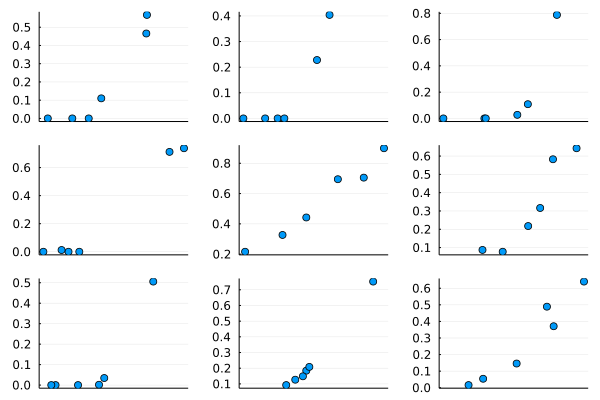

In [29]:
np = 3

pl = plot(layout=(np, np), legend=nothing, link=:x, xticks=nothing)
for j in 1:np^2
    mkt = Market(6)
    p_star = quickeq(mkt)
        # Notice the strong correlation
    scatter!(pl, subplot = j, mkt.gamma - mkt.capacities, p_star)
end
pl

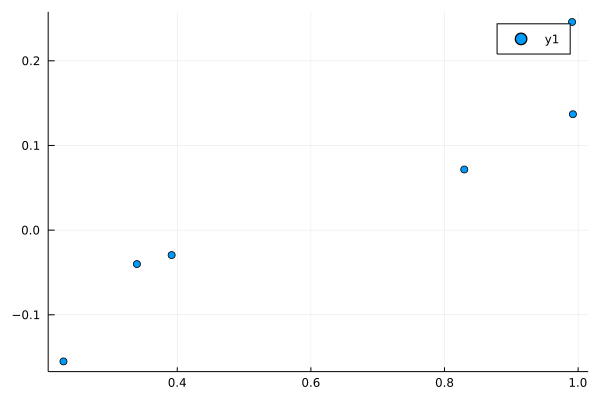

In [6]:
mkt = Market(6)
p_star = quickeq(mkt)

A, sort_order = demandmatrix(mkt, p_star)
demand(mkt, p_star)[sort_order] ≈ A * p_star[sort_order] + mkt.gamma[sort_order]

i = 1


true

In [5]:
inv_sort_order = invperm(sort_order)
B = A[inv_sort_order, inv_sort_order]

6×6 Matrix{Float64}:
 -0.287749    0.0   0.0         0.0396838   0.0        0.0
  0.0678506  -1.0   0.0449909   0.0231617   0.248809   0.470403
  0.0461063   0.0  -0.160231    0.015739    0.0        0.0
  0.0         0.0   0.0        -0.137911    0.0        0.0
  0.113526    0.0   0.0752776   0.0387535  -0.469808   0.0
  0.0602668   0.0   0.0399622   0.0205729   0.220999  -0.470403

In [352]:
idx = p_star .> 0

6-element BitVector:
 1
 0
 0
 1
 0
 0

In [353]:
demand(mkt, p_star)

6-element Vector{Float64}:
 0.15842191056062965
 0.21676289577981173
 0.279139394838357
 0.011985400648549865
 0.1411434002164737
 0.19254699795617808

In [354]:
B[:, idx] * inv(B)[idx, :] * (mkt.capacities - mkt.gamma) + mkt.gamma

6-element Vector{Float64}:
 0.15842191056062963
 0.21676289577981164
 0.2791393948383569
 0.011985400648549804
 0.14114340021647367
 0.19254699795617802

In [355]:
# Block matrix described below
# [ 0 T ;
#   0 I ] =
round.((B[:, idx] * inv(B)[idx, :])[sort_order, sort_order], digits=4)

6×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  -0.2613  -0.2613
 0.0  0.0  0.0  0.0  -0.3365  -0.3365
 0.0  0.0  0.0  0.0  -0.1701  -0.1701
 0.0  0.0  0.0  0.0  -0.2321  -0.2321
 0.0  0.0  0.0  0.0   1.0      0.0
 0.0  0.0  0.0  0.0   0.0      1.0

## References

- Abdulkadiroğlu, Atila, Yeon-Koo Che, and Yosuke Yasuda. 2015. &ldquo;Expanding &lsquo;Choice&rsquo; in School Choice.&rdquo; *American Economic Journal: Microeconomics* 7, no. 1 (Feb.): 1&ndash;42.